# scSurvival Tutorial in Python

## Introduction 
In this tutorial, we will demonstrate how to use scSurvival on the scanpy/anndata objects in Python. The package `scSurvival` is developed in Python, so it is more natural to integrate `scanpy` with scSurvival pipeline. 

## 0. Installation
If you haven't install the `scSurvival`, you can run the following magic command in this jupyter notebook. In this tutorial, the `scanpy` pacakage is required, you can also install it here if needed. 

In [ ]:
%pip install -e ..
%pip install scanpy
%pip install requests

Then, let's import the required packages:

In [1]:
from scSurvival import scSurvivalRun, PredictIndSample
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from tqdm import tqdm, trange
import scanpy as sc
from sklearn.cluster import KMeans

## scSurvival example
First, we need to download the prepared simulated dataset and extract it. This can be done directly in Python using the `wget` and `tarfile` packages.

In [ ]:
import os
import tarfile
import requests

def download_with_progress(url, save_path):
    response = requests.get(url, stream=True)
    total = int(response.headers.get('content-length', 0))
    with open(save_path, 'wb') as f, tqdm(
        total=total,
        unit='B',
        unit_scale=True,
        unit_divisor=1024,
        desc=save_path
    ) as bar:
        for chunk in response.iter_content(chunk_size=8192):
            if chunk:
                f.write(chunk)
                bar.update(len(chunk))

url = 'https://xialab.s3.us-west-2.amazonaws.com/tools/scSurvival/simulated_data.tar.gz'
save_path = './data/simulated_data.tar.gz'

os.makedirs("data", exist_ok=True)
print('Downloading data...')
download_with_progress(url, save_path)    

with tarfile.open(save_path, "r:gz") as tar:
    print('Extracting files...')
    tar.extractall(path="data")

print('Done!')

./data/simulated_data.tar.gz: 100%|██████████| 278M/278M [00:22<00:00, 13.2MB/s] 


Extracting files...
Done!


### Perform scSurvival analysis
#### Load data to scanpy

In [4]:
adata = sc.read_h5ad('./data/sc_cohort_adata.h5ad')
clinic = pd.read_csv('./data/surv_info.csv', index_col=0)
surv = clinic[['time', 'status']].copy()
surv['time'] = surv['time'].astype(float)
surv['status'] = surv['status'].astype(int)
print(adata)
print(surv.head())

AnnData object with n_obs × n_vars = 100000 × 2000
    obs: 'sample'
       time  status
bulk1   1.0       1
bulk2   2.0       1
bulk3   3.0       1
bulk4   4.0       1
bulk5   5.0       0


#### Run scSurvival
The input to scSurvival consists of a single-cell cohort dataset, where each patient is represented by a single-cell gene expression matrix along with their corresponding survival information. In addition, scSurvival is capable of simultaneously incorporating covariates into the model. Here, we randomly simulate several covariates to be included in the analysis. Since these covariates are generated at random, they are expected—at least in theory—to be excluded by the model during training and should not interfere with the identification of risk-associated cell populations.

Finetuning:  93%|█████████▎| 463/500 [10:10<00:48,  1.32s/it, ae_loss=-287, atten_entropy=0.711, cox_loss=1.97, loss=-0.896] 


Added hazard and attention to adata.obs.
Added patient_hazards to surv.


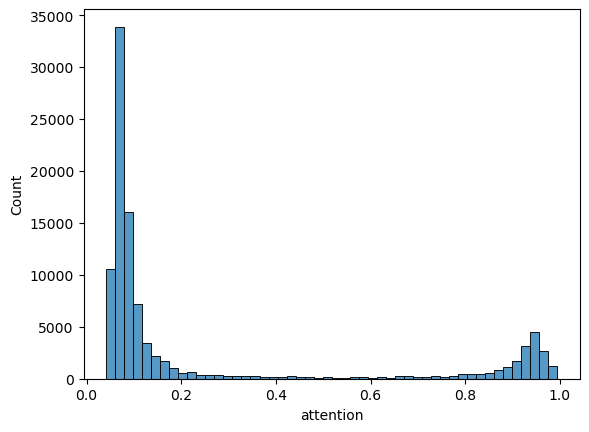

In [ ]:
covariates = pd.DataFrame(index=surv.index)
covariates['stage'] = np.random.randint(0, 3, surv.shape[0])
covariates['sex'] = np.random.randint(0, 2, surv.shape[0])
covariates = covariates.astype(str)
covariates['age'] = np.random.randint(0, 100, surv.shape[0]) 

adata, surv, model = scSurvivalRun(
    adata, 
    sample_column='sample',
    surv=surv,
    covariates=covariates,
    # validate=True, 
    # batch_key='sample',
    feature_flavor='AE',
    entropy_threshold=0.7,
    pretrain_epochs=200,
    epochs=500,
    patience=100,
    fitnetune_strategy='alternating'
)  

sns.histplot(adata.obs['attention'], bins=50)
plt.show()

scSurvival also supports multiple feature extraction strategies to accommodate different scenarios. Users can specify the `feature_flavor` parameter: when set to 'PCA', the model uses principal components as input features for rapid analysis, and if no PCA result is available in adata.obsm, it will be computed automatically; when set to 'Custom', users can directly provide custom features stored in adata.obsm[feature_key], in which case the `feature_key` must be explicitly specified. In addition, when feature_flavor is set to 'AE', the reconstruction distribution (set by parameter `rec_likelihood`) can be chosen between 'ZIG' (Zero-inflated Gaussian) and 'G' (Gaussian), thereby retaining the advantages of the default ZIG-VAE architecture while offering more flexible options for feature modeling.

#### Show results 

##### Results for scSurvival patient hazard score and covariates
After training, scSurvival automatically integrates both the patient-level hazard scores derived from single-cell expression data and the effects of covariates. As shown, the scSurvival-derived hazard score contributes significantly to survival prediction, while the simulated covariates show no significant association—consistent with our expectations.

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
age,-0.005390,0.994624,0.110514,-0.221994,0.211213,0.800920,1.235176,0.0,-0.048777,9.610974e-01,0.057245
stage_1,-0.235692,0.790024,0.245796,-0.717443,0.246060,0.487999,1.278976,0.0,-0.958891,3.376136e-01,1.566555
stage_2,0.125212,1.133389,0.251024,-0.366786,0.617210,0.692958,1.853750,0.0,0.498805,6.179170e-01,0.694515
sex_1,-0.019091,0.981090,0.210934,-0.432514,0.394332,0.648876,1.483393,0.0,-0.090506,9.278849e-01,0.107982
scSurvival_hazard,0.438931,1.551048,0.039504,0.361504,0.516358,1.435487,1.675913,0.0,11.110971,1.109471e-28,92.864115


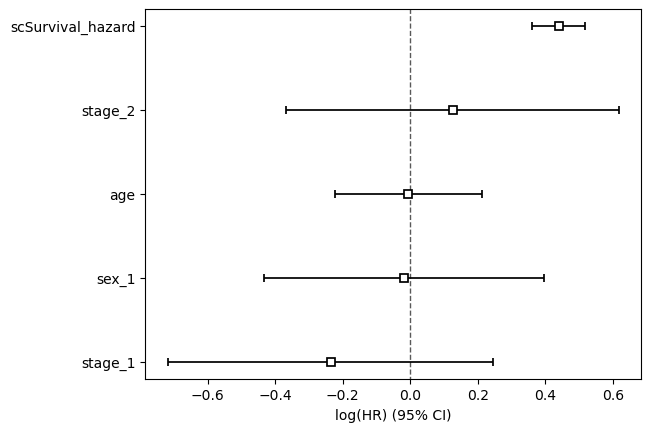

In [10]:
model.cph.plot()
model.covariate_coef

##### Results for risk-cell identification
Next, we present the results of risk cell subpopulation identification by scSurvival. For convenience, instead of using the full simulated single-cell cohort, we visualize the results on the initial single-cell dataset used to generate the simulation (see the R tutorial for details on data generation). This single-cell dataset has been packaged into an .h5ad file and can be directly loaded and visualized using scanpy. We first visualize the ground truth risk-associated cell subpopulations in the simulated dataset.

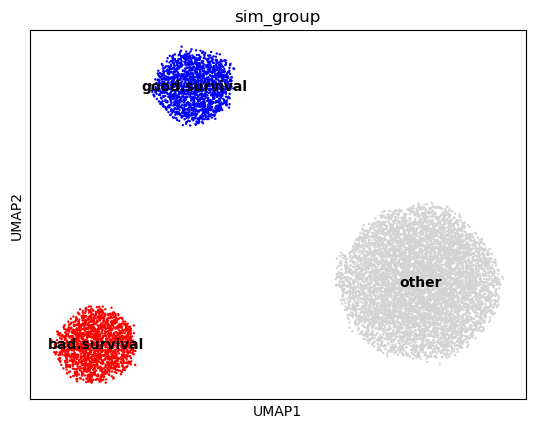

In [11]:
sc_adata = sc.read_h5ad('./data/sc_adata_raw.h5ad')
sc_adata.raw = sc_adata.copy()

sc.pp.scale(sc_adata, max_value=10)
sc.pp.pca(sc_adata, zero_center=False)
sc.pp.neighbors(sc_adata, use_rep='X_pca', n_neighbors=15, n_pcs=10)
sc.tl.umap(sc_adata)
sc.pl.umap(sc_adata, color=['sim_group'], legend_loc='on data', palette=['red', 'blue', 'lightgray'])

We then apply the trained scSurvival model to the single-cell data for inference, and visualize the distributions of attention weights and cell-level risk scores.

gene missing rate: 0.00%
Added hazard and attention to adata_new.obs.


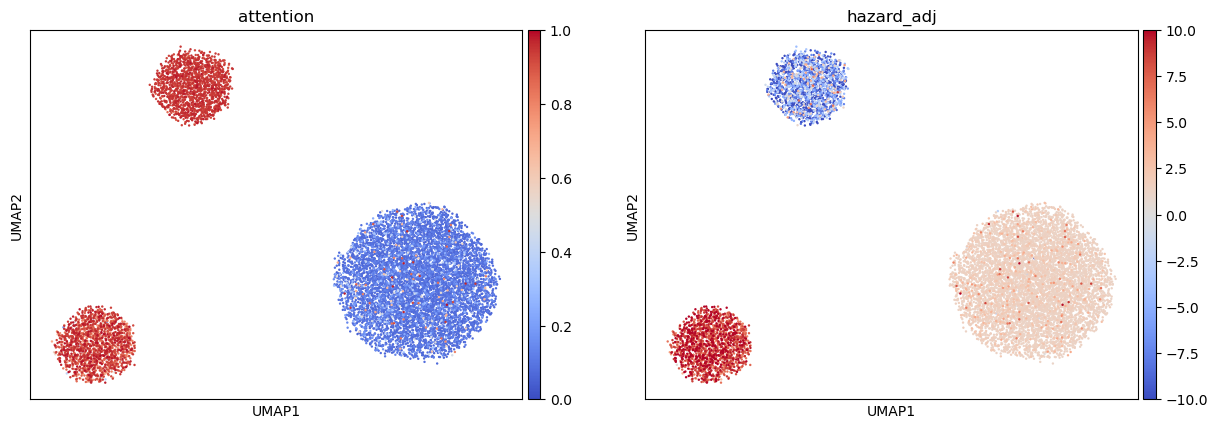

In [12]:
sc_adata = sc_adata.raw.to_adata()
sc_adata, _ = PredictIndSample(sc_adata, adata, model)
sc.pl.umap(sc_adata, color=['attention', 'hazard_adj'], vmin=[0, -10], vmax=[1, 10], cmap='coolwarm', ncols=2)

Finally, we classify cells based on their attention weights and risk scores. The resulting groups closely resemble the ground truth subpopulations, demonstrating that scSurvival can effectively identify risk-associated cell subpopulations.

attention cutoff: 0.49454132


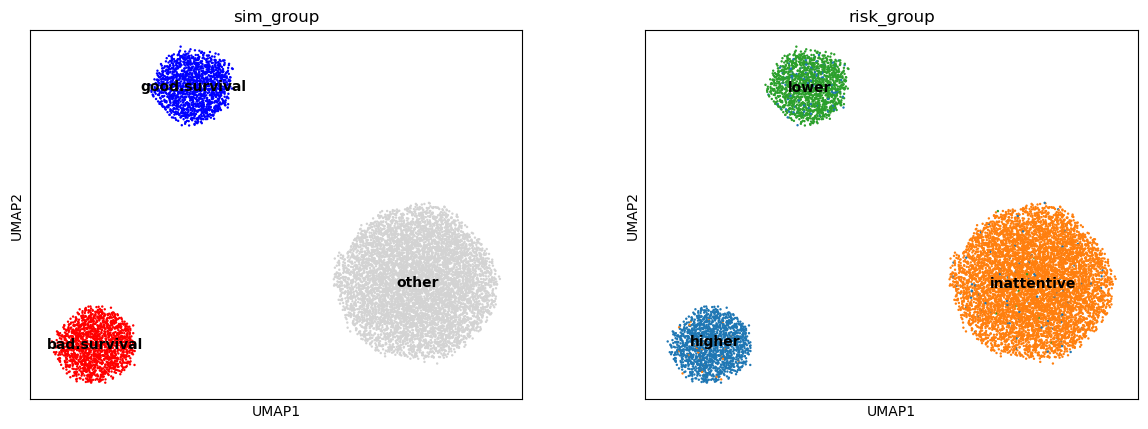

In [13]:
data = adata.obs['attention'].values.reshape(-1, 1)
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(data)
labels = kmeans.labels_
cluster_centers = kmeans.cluster_centers_
atten_thr = cluster_centers.flatten().mean()
print("attention cutoff:", atten_thr)

hazard = sc_adata.obs.loc[:, 'hazard_adj']
attention = sc_adata.obs.loc[:, 'attention']
risk_group = np.full(sc_adata.shape[0], 'inattentive', dtype=object)
risk_group[(hazard > 0) & (attention > atten_thr)] = 'higher'
risk_group[(hazard < 0) & (attention > atten_thr)] = 'lower'
sc_adata.obs['risk_group'] = risk_group

sc.pl.umap(sc_adata, color=['sim_group', 'risk_group'], legend_loc='on data')

<!-- ## Reference
scSurvial: survival analysis from single-cell cohort data at cellular resolution.

Tao Ren, Faming Zhao, Canping Chen, Ling-Yun Wu and Zheng Xia -->